In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
/device:GPU:0
Num GPUs Available:  1


In [12]:
!pip install -q -U keras-tuner
import os
import cv2
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import IPython
from PIL import Image
import kerastuner as kt
import tensorflow as tf
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, Conv2D, MaxPool2D, BatchNormalization,Dense,GlobalAveragePooling2D,Flatten,SeparableConv2D
from tensorflow.keras import Model,layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from kerastuner.engine.hyperparameters import HyperParameters
from pathlib import Path
color = sns.color_palette()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#extracting test Images from Zip file
local_zip = '/content/drive/My Drive/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
IMG_SIZE = 200
data_dir = Path('/tmp/chest_xray')
test_dir = data_dir/'test'

In [6]:
#loading the Augmented Training Images 
train_images = pd.read_pickle(r'/content/drive/My Drive/X_200.pickle')
train_labels = pd.read_pickle(r'/content/drive/My Drive/y_200.pickle')

In [8]:
#Shuffling the data
train_images = np.array(train_images)
train_labels = np.array(train_labels)
idx = np.random.permutation(len(train_images))
train_images,train_labels = train_images[idx], train_labels[idx]
print (train_images.shape)
print (train_labels.shape)

(7898, 200, 200, 3)
(7898,)


In [10]:
def get_data(dir):
    normal_cases_dir = dir/'NORMAL'
    pneumonia_cases_dir = dir/'PNEUMONIA'

    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    data = []
    labels = []

    for img in normal_cases:
        img = cv2.imread(str(img))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if img.shape[2] == 1:
            img = np.dstack([img,img,img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255
        label = 0
        data.append(img)
        labels.append(label)

    for img in pneumonia_cases:
        img = cv2.imread(str(img))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if img.shape[2]==1:
            img = np.dstack([img,img,img])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255
        label = 1
        data.append(img)
        labels.append(label)  
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [7]:
#Downloading Weights of InceptionV3 for Transfer Learning
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-10-31 09:30:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 209.85.145.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  51.4MB/s    in 1.6s    

2020-10-31 09:30:21 (51.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 10, 10, 768)


In [19]:
def model_builder(hp):
    l1_regularizer = hp.Choice('l1', values = [1e-3,1e-4,1e-5,1e-6]) #l1_regularization
    l2_regularizer = hp.Choice('l2', values = [1e-3,1e-4,1e-5,1e-6]) #l2_regularization
    dropout_prob =hp.Choice('dropout_prob', values = [0.2,0.25,0.3,0.35,0.4]) #Dropout 
    x = Conv2D(64,(3,3),activation = 'relu', name = 'conv1',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(last_output)
    x = Conv2D(64,(3,3),activation = 'relu', name = 'conv2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
    x = MaxPool2D((2,2),name = 'pool_1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv3',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv4',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization(name='bn_1')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
    x = Dropout(dropout_prob)(x)
    x = Dense(96, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
    x = Dropout(dropout_prob)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    model = Model(pre_trained_model.input,x)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    return model

In [15]:
test_data, test_labels = get_data(test_dir)
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 200, 200, 3)
Total number of labels: (624,)


In [20]:
#Tuning the Hyperpaameters using Keras tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'hyperparamters2',
                     project_name = 'trails')  

In [21]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [22]:
tuner.search(train_images, train_labels, epochs = 10, validation_data = (test_data, test_labels), callbacks = [ClearTrainingOutput()])
# Getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model = tuner.hypermodel.build(best_hps)

INFO:tensorflow:Oracle triggered exit


In [23]:
#using Earlystopping to get the optimal results
epochs_to_wait_for_improve = 20
n_epochs = 50
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('BINARY'+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_images,train_labels , validation_data = (test_data,test_labels),
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/50
247/247 [==============================] - ETA: 0s - loss: 2.9767 - precision: 0.9604 - recall: 0.9525 - accuracy: 0.9575
Epoch 00001: val_accuracy improved from -inf to 0.62981, saving model to BINARY.h5
247/247 [==============================] - 19s 79ms/step - loss: 2.9767 - precision: 0.9604 - recall: 0.9525 - accuracy: 0.9575 - val_loss: 1.1394 - val_precision: 0.6280 - val_recall: 1.0000 - val_accuracy: 0.6298
Epoch 2/50
247/247 [==============================] - ETA: 0s - loss: 0.3694 - precision: 0.9766 - recall: 0.9595 - accuracy: 0.9689
Epoch 00002: val_accuracy improved from 0.62981 to 0.84455, saving model to BINARY.h5
247/247 [==============================] - 18s 73ms/step - loss: 0.3694 - precision: 0.9766 - recall: 0.9595 - accuracy: 0.9689 - val_loss: 0.6385 - val_precision: 0.8021 - val_recall: 0.9974 - val_accuracy: 0.8446
Epoch 3/50
247/247 [==============================] - ETA: 0s - loss: 0.3023 - precision: 0.9764 - recall: 0.9695 - accuracy: 0.9735
Ep

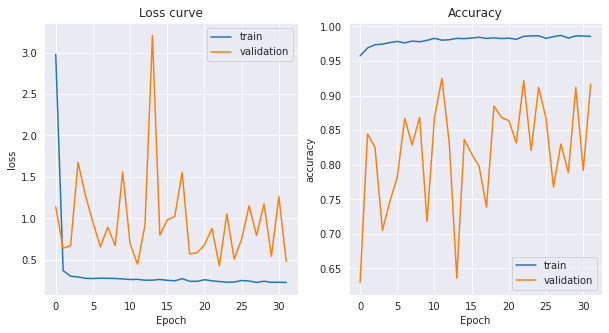

In [24]:
sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [25]:
eval = model.evaluate(test_data, test_labels)

20/20 [==============================] - 1s 62ms/step - loss: 0.4778 - precision: 0.9142 - recall: 0.9564 - accuracy: 0.9167


In [26]:
def get_predictions(model, test_data):
    pred = model.predict(test_data)
    predictions = []
    for i in pred:
        if i>0.5:
            predictions.append(1)
        else :
            predictions.append(0)
            predictions = np.array(predictions)
    return predictions 

#Getting Predictions  
predictions = get_predictions(model,test_data)

<Figure size 432x288 with 0 Axes>

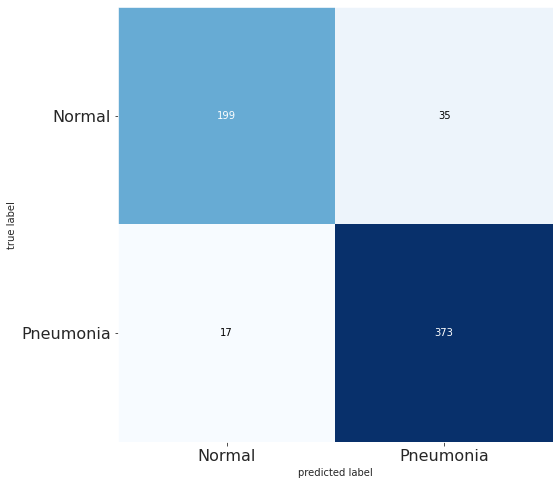

In [27]:
#Plotting the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()